# Exploring 2017 data with DP hits

In [1]:
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt     

We can start by exploring the data file.

In [2]:
fname = "data/nimSkim_data.root"
dq_dict = uproot.open(fname)["save"]

In [3]:
dq_dict.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rawEvent             | SRawEvent                | AsGroup(<TBranchElement 'ra...
rawEvent/TObject     | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
rawEvent/TObject/... | uint32_t                 | AsDtype('>u4')
rawEvent/TObject/... | uint8_t                  | AsDtype('uint8')
rawEvent/fRunID      | int32_t                  | AsDtype('>i4')
rawEvent/fEventID    | int32_t                  | AsDtype('>i4')
rawEvent/fSpillID    | int32_t                  | AsDtype('>i4')
rawEvent/fTrigger... | int32_t                  | AsDtype('>i4')
rawEvent/fTargetPos  | int16_t                  | AsDtype('>i2')
rawEvent/fTurnID     | int32_t                  | AsDtype('>i4')
rawEvent/fRFID       | int32_t                  | AsDtype('>i4')
rawEvent/fIntensi... | int32_t[33]              | AsDtype("('>i4', (33,))")
rawEvent/fTri

In [4]:
dq_dict['rawEvent'].keys()

['TObject',
 'TObject/fUniqueID',
 'TObject/fBits',
 'fRunID',
 'fEventID',
 'fSpillID',
 'fTriggerBits',
 'fTargetPos',
 'fTurnID',
 'fRFID',
 'fIntensity[33]',
 'fTriggerEmu',
 'fNRoads[4]',
 'fNHits[63]',
 'fAllHits',
 'fAllHits/fAllHits.fUniqueID',
 'fAllHits/fAllHits.fBits',
 'fAllHits/fAllHits.index',
 'fAllHits/fAllHits.detectorID',
 'fAllHits/fAllHits.elementID',
 'fAllHits/fAllHits.tdcTime',
 'fAllHits/fAllHits.driftDistance',
 'fAllHits/fAllHits.pos',
 'fAllHits/fAllHits.flag',
 'fTriggerHits',
 'fTriggerHits/fTriggerHits.fUniqueID',
 'fTriggerHits/fTriggerHits.fBits',
 'fTriggerHits/fTriggerHits.index',
 'fTriggerHits/fTriggerHits.detectorID',
 'fTriggerHits/fTriggerHits.elementID',
 'fTriggerHits/fTriggerHits.tdcTime',
 'fTriggerHits/fTriggerHits.driftDistance',
 'fTriggerHits/fTriggerHits.pos',
 'fTriggerHits/fTriggerHits.flag']

Let's define a dictionary with triggerbits, the detector ID and the element ID (hodoscope bar).

In [5]:
events = dq_dict['rawEvent'].arrays(["fTriggerBits","fAllHits/fAllHits.detectorID","fAllHits.elementID"], 
                                    "fTriggerBits>0",  # cut on triggerbits>0
                                   )
dq_events = ak.zip({
    "hits": ak.zip({
        "triggerbits": events['fTriggerBits'],
        "detectorID": events["fAllHits/fAllHits.detectorID"],
        "elementID": events["fAllHits.elementID"]
    })
})

hits = dq_events.hits

In [6]:
hits.detectorID

<Array [[], [1, 1, 1, 1, ... 60], [4, 23, 24]] type='423646 * var * int16'>

In [7]:
hits.triggerbits

<Array [[], [64, 64, 64, ... [128, 128, 128]] type='423646 * var * int32'>

In [8]:
# now we need to create a trigger mask that can filter by triggerbits
# here is a reference on what the triggerbits mean:
# https://github.com/meeg/kTrackerDark/blob/darkphoton/inc/SRawEvent.h#L216-L227
"""
MATRIX1 = 1 << 0 = 1
MATRIX2 = 1 << 1 = 2
MATRIX3 = 1 << 2 = 4
MATRIX4 = 1 << 3 = 8
MATRIX5 = 1 << 4 = 16
NIM1 = 1 << 5 = 32
NIM2 = 1 << 6 = 64
NIM3 = 1 << 7 = 128
"""
trigger_to_bits = {
    'matrix1': 1,
    'nim1': 32,
    'nim2': 64,
    'nim3': 128,
}

# events with random hits are selected with the NIM1 | NIM3 mask
# for an event to be selected by a trigger it needs to pass: (hits.triggerbits & X)!=0
def is_triggered_by(triggerbits,bits):
    triggered = ak.zeros_like(triggerbits) != 0
    for b in bits:
        triggered = triggered | (triggerbits & trigger_to_bits[b] !=0)
    return triggered

trigger_mask = is_triggered_by(hits.triggerbits,['nim1','nim3'])

In [9]:
print('Trigger bits ',hits.triggerbits)
print('Trigger bits & nim1 ',hits.triggerbits & trigger_to_bits['nim1'])
print('Trigger bits & nim3 ',hits.triggerbits & trigger_to_bits['nim3'])
print('Trigger bits & nim1 mask ',hits.triggerbits & trigger_to_bits['nim1'] !=0)
print('Trigger bits & nim3 mask ',hits.triggerbits & trigger_to_bits['nim3'] !=0)
print('Trigger mask ',trigger_mask)

Trigger bits  [[], [64, 64, 64, 64, 64, 64, 64, 64, ... 128, 128, 128, 128, 128], [128, 128, 128]]
Trigger bits & nim1  [[], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0]]
Trigger bits & nim3  [[], [0, 0, 0, 0, 0, 0, 0, 0, 0, ... 128, 128, 128, 128, 128, 128], [128, 128, 128]]
Trigger bits & nim1 mask  [[], [False, False, False, False, False, ... False, False], [False, False, False]]
Trigger bits & nim3 mask  [[], [False, False, False, False, False, False, ... True, True], [True, True, True]]
Trigger mask  [[], [False, False, False, False, False, False, ... True, True], [True, True, True]]


In [10]:
# apply trigger mask
triggered_hits = hits[trigger_mask]
matrix1_hits = hits[is_triggered_by(hits.triggerbits,['matrix1'])]

We can map our hits to the detector ID and create a dictionary that allows to fill histograms

In [11]:
# detector ID map
detector_to_detid = {
    'DP1':{
        'TL': 55,
        'TR': 56,
        'BL': 57,
        'BR': 58,
    },
    'DP2':{
        'TL': 59,
        'TR': 60,
        'BL': 61,
        'BR': 62,
    },
}

def get_detector(arr, detid):
    if isinstance(detid,list)>0:
        mask = (arr.detectorID >= detid[0]) & (arr.detectorID <= detid[1])
    else:
        mask = arr.detectorID==detid
    return mask

def get_dphits(arr):
    dphits = {}
    for detector in ['DP1','DP2']:
        dphits[detector] = {}
        for subdet in ['TL','TR','BL','BR']:
            detid = detector_to_detid[detector][subdet]
            detector_mask = get_detector(arr,detid)
            detector_id = arr.detectorID[detector_mask]
            bar = arr.elementID[detector_mask]
            
            dphits[detector][subdet] = {}
            dphits[detector][subdet]['nhits_per_event'] = ak.count(detector_id,axis=1)
            dphits[detector][subdet]['nhits'] = ak.count(detector_id)
            dphits[detector][subdet]['nhits_mean'] = ak.mean(ak.count(detector_id,axis=1))
            dphits[detector][subdet]['bar'] = bar
    return dphits

In [12]:
dphits = get_dphits(hits)
dphits_triggered = get_dphits(triggered_hits)
dphits_matrix1 = get_dphits(matrix1_hits)

In [13]:
dphits['DP1']['TL']['nhits_mean']

4.771214646190452

In [14]:
# Let's fill the bars depending on the direction of the quadrant
# The DP hodoscopes are all segmented in y i.e. give y direction
# TL is +x,+y
# TR is -x,+y
# BL is +x,-y
# BR is -x,-y
print(dphits_triggered['DP1']['TL']['bar'])
bar_y = ak.flatten(ak.fill_none(dphits_triggered['DP1']['TL']['bar'],-1,axis=-1)).to_numpy()
print(bar_y)
print(bar_y * -1)
print('TL'[-1])

[[], [], [21, 21, 21], [], [8], [1, ... [], [3, 6, 7, 7, 9, 11, 13, 13, 14, 15], []]
[21 21 21 ... 13 14 15]
[-21 -21 -21 ... -13 -14 -15]
L


In [15]:
dphits_triggered['DP1']['TL']['nhits']

754014

In [16]:
def draw_nhits(arr):
    for detector in arr.keys():
        fig, ax = plt.subplots(1, 2, figsize=(8,4))
        width = 0.35
        x = arr[detector]
        ax[0].bar(x.keys(),[x[key]['nhits'] for key in x.keys()],width)
        ax[0].set_ylabel("Total hits No.")
        ax[0].set_title('No. of hits per quadrant for all events')
        ax[1].bar(x.keys(),[x[key]['nhits_mean'] for key in x.keys()],width)
        ax[1].set_ylabel("Hits per quadrant per event (average)")
        ax[1].set_title('No. of hits per quadrant per event (Average)')
        fig.suptitle(f'{detector} hits', fontsize=16)
        fig.tight_layout()

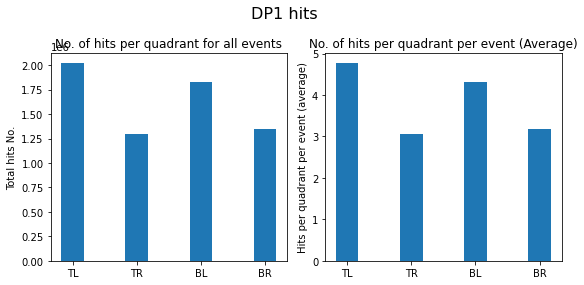

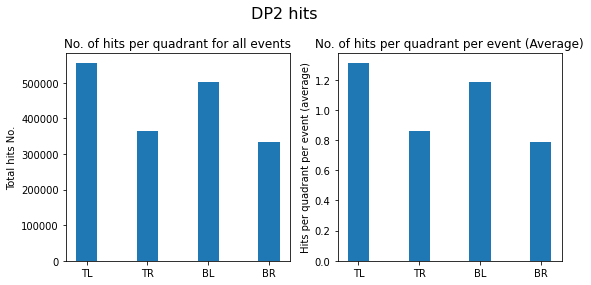

In [17]:
draw_nhits(dphits)

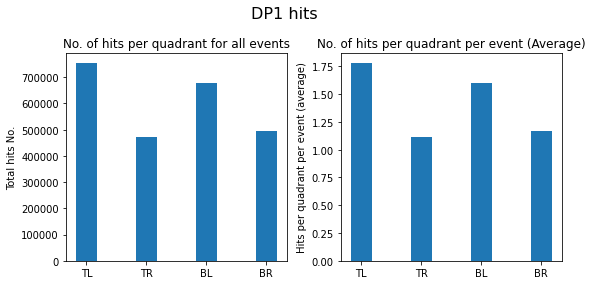

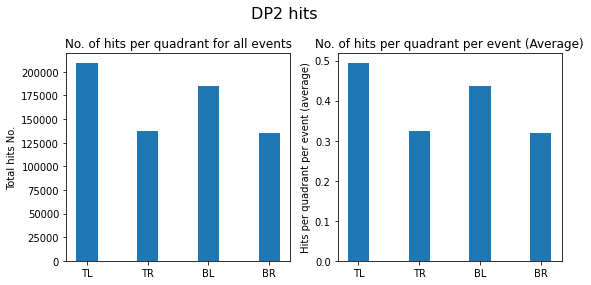

In [18]:
draw_nhits(dphits_triggered)

In [58]:
# now we can fill the distribution of hits in each DP quadrant
# this uses hist from scikit hep: https://github.com/scikit-hep/hist
import hist as hist2
trigger_cat = hist2.axis.StrCategory([], name='trigger', growth=True)
detector_cat = hist2.axis.StrCategory([], name='detector', growth=True)
dp1bar_axis = hist2.axis.Regular(80,0,80, name='bar', label=r'DP1 Hodoscope bar') # 80 bars per quadrant
dp2bar_axis = hist2.axis.Regular(50,0,50, name='bar', label=r'DP2 Hodoscope bar') # 50 bars per quadrant

barx_axis = hist2.axis.Regular(2,-80,80, name='bar_x', label=r'Hodoscope bar x')
dp1bary_axis = hist2.axis.Regular(160,-80,80, name='bar_y', label=r'DP1 Hodoscope bar y')
dp2bary_axis = hist2.axis.Regular(100,-50,50, name='bar_y', label=r'DP2 Hodoscope bar y') 

hists = {
        'hits_DP1': hist2.Hist(
            detector_cat,
            trigger_cat,
            dp1bar_axis,
            barx_axis,
            dp1bary_axis,
        ),
        'hits_DP2': hist2.Hist(
            detector_cat,
            trigger_cat,
            dp2bar_axis,
            barx_axis,
            dp2bary_axis,
        ),
}

In [20]:
def fill_nhits(arr,hsts,trigger='random'):
    for detector in arr.keys():
        x = arr[detector]
        for subdet in x.keys():
            bar = ak.flatten(ak.fill_none(x[subdet]['bar'],-1,axis=-1)).to_numpy()
            if subdet[-2]=='B':
                bar_y = bar * -1
            else:
                bar_y = bar
            if subdet[-1]=='L':
                bar_x = -40
            else:
                bar_x = 40
            hsts['hits_%s'%detector].fill(
                detector=subdet,
                trigger=trigger,
                bar=bar,
                bar_x=bar_x,
                bar_y=bar_y,
            )

In [59]:
fill_nhits(dphits_triggered,hists)
fill_nhits(dphits,hists,trigger='all')
fill_nhits(dphits_matrix1,hists,trigger='matrix1')

In [22]:
hists['hits_DP2']

Hist(
  StrCategory(['TL', 'TR', 'BL', 'BR'], growth=True, name='detector', label='detector'),
  StrCategory(['random', 'all', 'matrix1'], growth=True, name='trigger', label='trigger'),
  Regular(50, 0, 50, name='bar', label='DP2 Hodoscope bar'),
  Regular(2, -80, 80, name='bar_x', label='Hodoscope bar x'),
  Regular(100, -50, 50, name='bar_y', label='DP2 Hodoscope bar y'),
  storage=Double()) # Sum: 2411661.0 (2435470.0 with flow)

In [75]:
import mplhep as hep
def draw_bar_distributions(hsts,trigger='random'):
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    colors = ['b','g','r','c']
    for it,detector in enumerate(['DP1','DP2']):
        for ic,subdet in enumerate(['TL','TR','BL','BR']):
            x = hsts['hits_%s'%detector][{"trigger":trigger,"detector":subdet,"bar_x":sum,"bar_y":sum}]
            hep.histplot(x,
                         ax = ax[it],
                         histtype='step', color=colors[ic], label=subdet,
                        )
        ax[it].legend()
        ax[it].set_title(f"{detector} {trigger} triggered hits")
        ax[it].set_xlabel(f"{detector} bars")
        ax[it].set_ylabel('Hits')
    fig.tight_layout()
    
def draw_2dbar_distributions(hsts,trigger='random'):
    for it,detector in enumerate(['DP1','DP2']):
        fig, ax = plt.subplots(1, 1, figsize=(4,4))
        x = hsts['hits_%s'%detector][{"trigger":trigger,"detector":sum,"bar":sum}]
        hep.hist2dplot(x,ax = ax)
        fig.tight_layout()

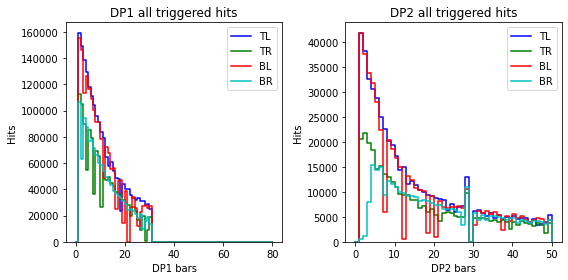

In [72]:
draw_bar_distributions(hists,"all")

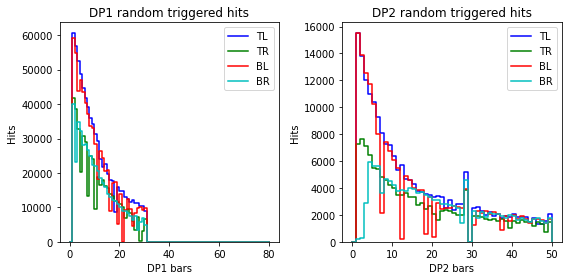

In [25]:
draw_bar_distributions(hists,"random")

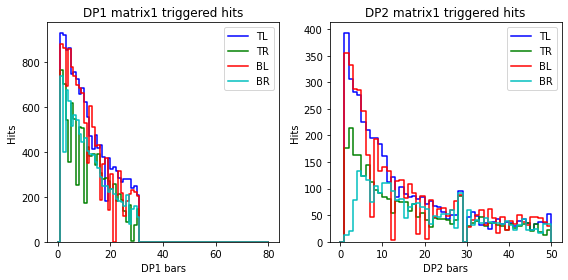

In [26]:
draw_bar_distributions(hists,"matrix1")

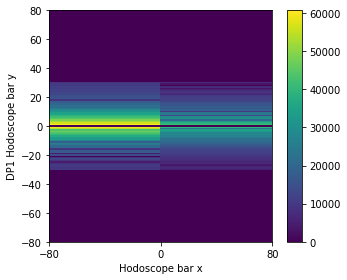

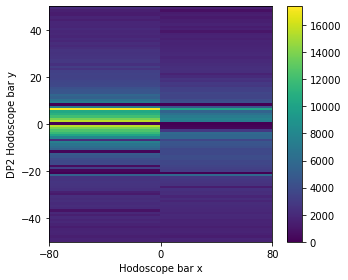

In [76]:
draw_2dbar_distributions(hists,"random")

Now, we can apply a mask on top of the random triggered hits, e.g. given hits in DP1 and DP2
We can start by requiring that events have hits in a given quadrant, e.g.

In [64]:
mask = ak.any(dphits_triggered['DP1']['TL']['bar'] > 0,axis=1) & ak.any(dphits_triggered['DP2']['TL']['bar'] > 0,axis=1)
print('mask ',mask)
# print(triggered_hits[mask].detectorID)

# e.g. we can require dphits_triggered in the same quadrant in DP1 and DP2
trigger_same_quad = ak.any(triggered_hits.triggerbits !=0,axis=1)
for quad in ['TL','TR','BL','BR']:
    trigger_same_quad = trigger_same_quad | (ak.any(dphits_triggered['DP1'][quad]['bar'] > 0,axis=1) \
                                            & ak.any(dphits_triggered['DP2'][quad]['bar'] > 0,axis=1))

# print('trig ',trigger_same_quad)
hits_same_quad = triggered_hits[trigger_same_quad]
# print('det ID', hits_same_quad.detectorID)
dphits_same_quad = get_dphits(hits_same_quad)

mask  [False, False, True, False, False, True, ... False, False, False, False, True, False]
nhits  754014
nevents 2.765531988248541


In [70]:
print('nhits ',dphits_same_quad['DP1']['TL']['nhits'])
print('nhits per event',dphits_same_quad['DP1']['TL']['nhits_per_event'])
print('nevents',ak.count(dphits_same_quad['DP1']['TL']['nhits_per_event'],axis=0))
print('n random events',ak.count(dphits_triggered['DP1']['TL']['nhits_per_event'],axis=0))


nhits  754014
nhits per event [3, 1, 7, 5, 2, 2, 1, 1, 0, 2, 1, 9, 1, ... 2, 3, 8, 5, 9, 5, 1, 2, 1, 8, 4, 10, 0]
nevents 272647
n random events 423646


In [60]:
fill_nhits(dphits_same_quad,hists,"samequad")

In [61]:
hists

{'hits_DP1': Hist(
   StrCategory(['TL', 'TR', 'BL', 'BR'], growth=True, name='detector', label='detector'),
   StrCategory(['random', 'all', 'matrix1', 'samequad'], growth=True, name='trigger', label='trigger'),
   Regular(80, 0, 80, name='bar', label='DP1 Hodoscope bar'),
   Regular(2, -80, 80, name='bar_x', label='Hodoscope bar x'),
   Regular(160, -80, 80, name='bar_y', label='DP1 Hodoscope bar y'),
   storage=Double()) # Sum: 11339920.0,
 'hits_DP2': Hist(
   StrCategory(['TL', 'TR', 'BL', 'BR'], growth=True, name='detector', label='detector'),
   StrCategory(['random', 'all', 'matrix1', 'samequad'], growth=True, name='trigger', label='trigger'),
   Regular(50, 0, 50, name='bar', label='DP2 Hodoscope bar'),
   Regular(2, -80, 80, name='bar_x', label='Hodoscope bar x'),
   Regular(100, -50, 50, name='bar_y', label='DP2 Hodoscope bar y'),
   storage=Double()) # Sum: 3070895.0 (3101410.0 with flow)}

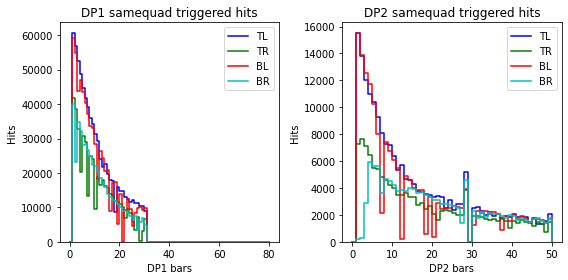

In [62]:
draw_bar_distributions(hists,"samequad")

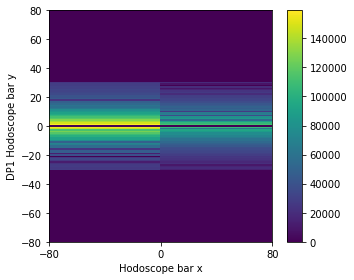

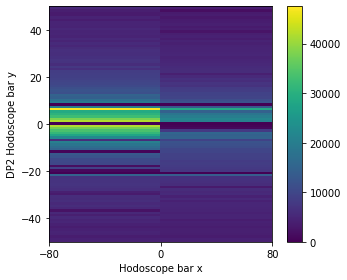

In [77]:
draw_2dbar_distributions(hists,"all")